In [7]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

import os
import yaml
import sqlalchemy

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display 
pd.options.display.max_columns = None
%matplotlib inline

In [2]:
with open('db_default_profile.yaml') as fd:
    config = yaml.load(fd)
    dburl = sqlalchemy.engine.url.URL(
        "postgres",
        host=config["host"],
        username=config["user"],
        database='johnson_county_ddj',
        password=config["pass"],
        port=config["port"],
    )
    engine_old = sqlalchemy.create_engine(dburl, poolclass=sqlalchemy.pool.QueuePool)

In [3]:
disp_cons_sql = """
WITH dist_res AS (
  SELECT DISTINCT * FROM  kit_bias_class_figs.model_adjustment_results_race_2way
)
, mg_rns_value AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base_value
  FROM dist_res
  WHERE past_train_end_time = train_end_time
    AND base_max_recall_ratio < {disparity_constraint}
)
, mg_rns_disp AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_max_recall_ratio ASC, base_value DESC, RANDOM()) AS rn_base_disparity
  FROM dist_res
  WHERE past_train_end_time = train_end_time
)
, base_mgs_hard_cons AS (
  -- Best-performaing (in terms of precision) model groups meeting the hard constraint on disparity
  SELECT * FROM mg_rns_value WHERE rn_base_value = 1
)
, base_mgs_soft_cons AS (
  -- For time/size/metric combinations with no model groups meeting the hard constraint, fill in with lowest-disparity model group
  SELECT
      COALESCE(h.model_group_id, d.model_group_id) AS model_group_id,
      COALESCE(h.train_end_time, d.train_end_time) AS train_end_time,
      COALESCE(h.list_size, d.list_size) AS list_size,
      COALESCE(h.metric, d.metric) AS metric,
      COALESCE(h.parameter, d.parameter) AS parameter
  FROM (SELECT * FROM mg_rns_disp WHERE rn_base_disparity = 1) as d
  LEFT JOIN base_mgs_hard_cons h USING(train_end_time, list_size, metric, parameter)
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Disparity Constraint {disparity_constraint} - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_white_to_nonwhite AS recall_white_to_nonwhite,
       r.base_recall_nonwhite_to_white AS recall_nonwhite_to_white,
       r.base_frac_white AS frac_white,
       r.base_frac_nonwhite AS frac_nonwhite
FROM dist_res r
JOIN base_mgs_soft_cons b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
ORDER BY train_end_time
;
"""


In [4]:
value_cons_sql = """
WITH dist_res AS (
  SELECT DISTINCT * FROM  kit_bias_class_figs.model_adjustment_results_race_2way
)
, mg_rns_value AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base_value
  FROM dist_res
  WHERE past_train_end_time = train_end_time
)
, best_mgs AS (
  SELECT * FROM mg_rns_value WHERE rn_base_value = 1
)
, value_dist_cons AS (
  SELECT r.*,
         row_number() OVER (PARTITION BY r.train_end_time, r.list_size, r.metric, r.parameter ORDER BY r.base_max_recall_ratio ASC, r.base_value DESC, RANDOM()) AS rn_base_disparity
  FROM dist_res r
  JOIN best_mgs b USING(train_end_time, list_size, metric, parameter)
  WHERE b.base_value - r.base_value <= {value_constraint}
)
, base_mgs_value_cons AS (
  -- Lowest-disparity model groups within hard constraint distance from best model group in terms of metric value
  SELECT * FROM value_dist_cons WHERE rn_base_disparity = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Accuracy Constraint {value_constraint} - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_white_to_nonwhite AS recall_white_to_nonwhite,
       r.base_recall_nonwhite_to_white AS recall_nonwhite_to_white,
       r.base_frac_white AS frac_white,
       r.base_frac_nonwhite AS frac_nonwhite
FROM dist_res r
JOIN base_mgs_value_cons b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
ORDER BY train_end_time
;
"""


In [52]:
res_dfs = []

for c in [1.0, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 2.0, 2.5]:
    df = pd.read_sql(disp_cons_sql.format(disparity_constraint=c), engine_old)
    res_dfs.append(df)

for c in [0.6, 0.5, 0.25, 0.2, 0.15, 0.10, 0.05, 0.0]:
    df = pd.read_sql(value_cons_sql.format(value_constraint=c), engine_old)
    res_dfs.append(df)

df = pd.concat(res_dfs)

In [53]:
df['constraint_type'] = df['strategy'].map(lambda x: x.split('-')[0].split(' ')[0])

(0.5, 1.8)

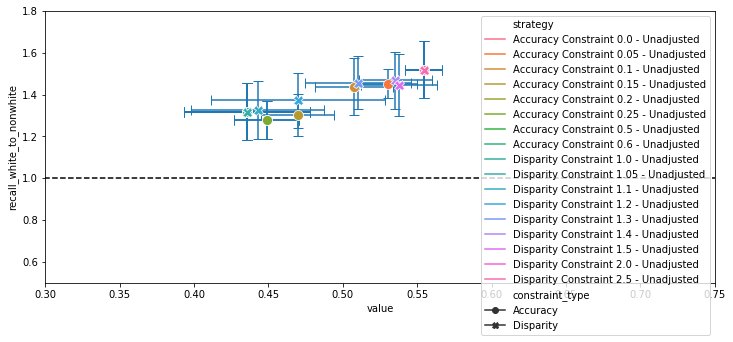

In [57]:
df['dataset'] = 'joco'
ts_df_1k = df.copy()
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df_1k.groupby(['constraint_type', 'strategy'])[['value', 'recall_white_to_nonwhite']].mean().reset_index(), 
              x='value', y='recall_white_to_nonwhite', 
              hue='strategy',
#              hue='dataset', 
#              marker="o", 
              style='constraint_type',
              markers=True,
#              color='dodgerblue',
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


x_coords = list(ts_df_1k.groupby(['constraint_type', 'strategy'])[['value', 'recall_white_to_nonwhite']].mean().reset_index()['value'].values)
y_coords = list(ts_df_1k.groupby(['constraint_type', 'strategy'])[['value', 'recall_white_to_nonwhite']].mean().reset_index()['recall_white_to_nonwhite'].values)
labels = list(ts_df_1k.groupby(['constraint_type', 'strategy'])['strategy'].min())

prec_errors = 1.96*ts_df_1k.groupby(['constraint_type', 'strategy'])['value'].sem().values
disp_errors = 1.96*ts_df_1k.groupby(['constraint_type', 'strategy'])['recall_white_to_nonwhite'].sem().values
colors = sns.color_palette().as_hex()[0]
ax.errorbar(x_coords, y_coords, 
            xerr=prec_errors, 
            yerr=disp_errors,
            ecolor=colors, 
            fmt=' ', zorder=-1, capsize=5)

ax.hlines(1.0, 0, 1, linestyles='dashed')

ax.set_xlim((0.3,0.75))
ax.set_ylim((0.5,1.80))
#ax.get_legend().remove()

In [17]:
ts_df_1k.groupby(['dataset', 'strategy'])[['value', 'recall_white_to_nonwhite']].mean().reset_index()

,dataset,strategy,value,recall_white_to_nonwhite
0,joco,Accuracy Constraint 0.0 - Unadjusted,0.554308,1.518707
1,joco,Accuracy Constraint 0.05 - Unadjusted,0.530400,1.452619
2,joco,Accuracy Constraint 0.1 - Unadjusted,0.507800,1.438104
3,joco,Accuracy Constraint 0.15 - Unadjusted,0.469800,1.302689
4,joco,Accuracy Constraint 0.2 - Unadjusted,0.449000,1.276797
5,joco,Accuracy Constraint 0.25 - Unadjusted,0.449000,1.276797
6,joco,Accuracy Constraint 0.5 - Unadjusted,0.435600,1.318078
7,joco,Accuracy Constraint 0.6 - Unadjusted,0.435600,1.318078
8,joco,Disparity Constraint 1.0 - Unadjusted,0.435600,1.318078
9,joco,Disparity Constraint 1.05 - Unadjusted,0.435600,1.318078


## JoCo Plotting

In [326]:
original_sql = """
WITH dist_res AS (
  SELECT DISTINCT * FROM  kit_bias_class_figs.model_adjustment_results_race_2way
)
, mg_rns_value AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base_value
  FROM dist_res
  WHERE past_train_end_time = train_end_time
)
, best_mgs AS (
  SELECT * FROM mg_rns_value WHERE rn_base_value = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Original'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_white_to_nonwhite AS recall_white_to_nonwhite,
       r.base_recall_nonwhite_to_white AS recall_nonwhite_to_white,
       r.base_frac_white AS frac_white,
       r.base_frac_nonwhite AS frac_nonwhite
FROM dist_res r
JOIN best_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
ORDER BY train_end_time
;
"""


In [328]:
j_res_dfs = []

letters = list(reversed(list('ABCDEFGH')))

for i, c in enumerate([1.0, 1.05, 1.1, 1.2, 1.3, 1.5, 2.0, 5.0]):
    df = pd.read_sql(disp_cons_sql.format(disparity_constraint=c), engine_old)
    df['Level'] = letters[i]
    j_res_dfs.append(df)

for i, c in enumerate([0.6, 0.5, 0.25, 0.2, 0.15, 0.10, 0.05, 0.0]):
    df = pd.read_sql(value_cons_sql.format(value_constraint=c), engine_old)
    df['Level'] = letters[i]
    j_res_dfs.append(df)

df = pd.read_sql(original_sql, engine_old)
df['Level'] = 'Original'
j_res_dfs.append(df)

j_df = pd.concat(j_res_dfs)
j_df['Constraint Type'] = j_df['strategy'].map(lambda x: x.split(' ')[0])
j_df['dataset'] = 'joco'

(0.5, 1.9)

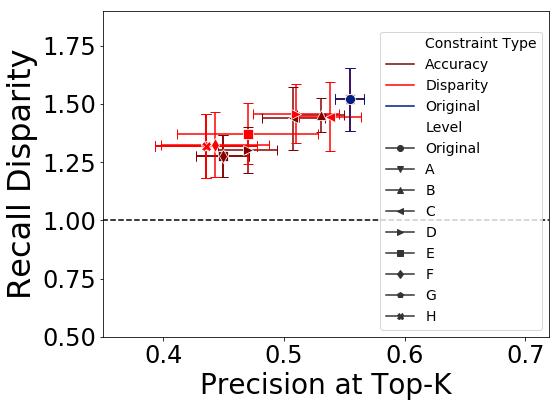

In [371]:
ts_df_1k = j_df.copy()
disp_col = 'recall_white_to_nonwhite'

colorlist = ['maroon', 
             'red',
             '#001c7f', #Original
             ]

fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(data=ts_df_1k.groupby(['Constraint Type', 'Level'])[['value', disp_col]].mean().reset_index(), 
              x='value', y=disp_col, 
              hue='Constraint Type',
              hue_order=['Accuracy', 'Disparity', 'Original'],
#              palette=sns.color_palette("nipy_spectral", 8) + list(reversed(sns.color_palette("nipy_spectral", 11))),
#              palette=sns.color_palette("nipy_spectral", 3),
              palette=colorlist,
#              hue_order=dc3_sort_ord,
#              hue='dataset', 
#              marker="o", 
              style='Level',
              markers=['o', 'v', '^', '<', '>', 's', 'd', 'p', 'X'],
              style_order=['Original'] + list(reversed(letters))[:8],
#              color='dodgerblue',
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


for i, t in enumerate(['Accuracy', 'Disparity', 'Original']):
    tmp_df = ts_df_1k.loc[ts_df_1k['Constraint Type'] == t].copy()

    x_coords = list(tmp_df.groupby(['Constraint Type', 'Level'])[['value', disp_col]].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['Constraint Type', 'Level'])[['value', disp_col]].mean().reset_index()[disp_col].values)
    labels = list(tmp_df.groupby(['Constraint Type', 'Level'])['Level'].min())

    prec_errors = 1.96*tmp_df.groupby(['Constraint Type', 'Level'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['Constraint Type', 'Level'])[disp_col].sem().values
    colors = colorlist[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
                ecolor=colors, 
                fmt=' ', zorder=-1, capsize=5)


ax.hlines(1.0, 0, 1, linestyles='dashed')

ax.legend(loc='lower right', fontsize=14)

ax.set_ylabel('Recall Disparity', fontsize=32)
ax.set_xlabel('Precision at Top-K', fontsize=28)

ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)

ax.set_xlim((0.35,0.72))
ax.set_ylim((0.5,1.90))
#ax.get_legend().remove()


## Donors Choose

In [37]:
with open('db_default_profile.yaml') as fd:
    config = yaml.load(fd)
    dburl = sqlalchemy.engine.url.URL(
        "postgres",
        host=config["host"],
        username=config["user"],
        database='donors',
        password=config["pass"],
        port=config["port"],
    )
    engine_donors = sqlalchemy.create_engine(dburl, poolclass=sqlalchemy.pool.QueuePool)

In [38]:
dc_disp_cons_sql = """
WITH dist_res AS (
  SELECT DISTINCT * FROM hemank_bias_2way.model_adjustment_results_plevel
)
, mg_rns_value AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base_value
  FROM dist_res
  WHERE past_train_end_time = train_end_time
    AND base_max_recall_ratio < {disparity_constraint}
)
, mg_rns_disp AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_max_recall_ratio ASC, base_value DESC, RANDOM()) AS rn_base_disparity
  FROM dist_res
  WHERE past_train_end_time = train_end_time
)
, base_mgs_hard_cons AS (
  -- Best-performaing (in terms of precision) model groups meeting the hard constraint on disparity
  SELECT * FROM mg_rns_value WHERE rn_base_value = 1
)
, base_mgs_soft_cons AS (
  -- For time/size/metric combinations with no model groups meeting the hard constraint, fill in with lowest-disparity model group
  SELECT
      COALESCE(h.model_group_id, d.model_group_id) AS model_group_id,
      COALESCE(h.train_end_time, d.train_end_time) AS train_end_time,
      COALESCE(h.list_size, d.list_size) AS list_size,
      COALESCE(h.metric, d.metric) AS metric,
      COALESCE(h.parameter, d.parameter) AS parameter
  FROM (SELECT * FROM mg_rns_disp WHERE rn_base_disparity = 1) as d
  LEFT JOIN base_mgs_hard_cons h USING(train_end_time, list_size, metric, parameter)
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Disparity Constraint {disparity_constraint} - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_highest_to_not_highest AS recall_highest_to_not,
       r.base_recall_not_highest_to_highest AS recall_not_to_highest,
       r.base_frac_highest AS frac_highest,
       r.base_frac_not_highest AS frac_not_highest
FROM dist_res r
JOIN base_mgs_soft_cons b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
ORDER BY train_end_time
;
"""


In [40]:
dc_value_cons_sql = """
WITH dist_res AS (
  SELECT DISTINCT * FROM  hemank_bias_2way.model_adjustment_results_plevel
)
, mg_rns_value AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base_value
  FROM dist_res
  WHERE past_train_end_time = train_end_time
)
, best_mgs AS (
  SELECT * FROM mg_rns_value WHERE rn_base_value = 1
)
, value_dist_cons AS (
  SELECT r.*,
         row_number() OVER (PARTITION BY r.train_end_time, r.list_size, r.metric, r.parameter ORDER BY r.base_max_recall_ratio ASC, r.base_value DESC, RANDOM()) AS rn_base_disparity
  FROM dist_res r
  JOIN best_mgs b USING(train_end_time, list_size, metric, parameter)
  WHERE b.base_value - r.base_value <= {value_constraint}
)
, base_mgs_value_cons AS (
  -- Lowest-disparity model groups within hard constraint distance from best model group in terms of metric value
  SELECT * FROM value_dist_cons WHERE rn_base_disparity = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Accuracy Constraint {value_constraint} - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_highest_to_not_highest AS recall_highest_to_not,
       r.base_recall_not_highest_to_highest AS recall_not_to_highest,
       r.base_frac_highest AS frac_highest,
       r.base_frac_not_highest AS frac_not_highest
FROM dist_res r
JOIN base_mgs_value_cons b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
ORDER BY train_end_time
;
"""


In [42]:
dc_res_dfs = []

for c in [1.0, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 2.0, 2.5, 3.0, 5.0]:
    df = pd.read_sql(dc_disp_cons_sql.format(disparity_constraint=c), engine_donors)
    dc_res_dfs.append(df)

for c in [0.6, 0.5, 0.25, 0.2, 0.15, 0.10, 0.05, 0.0]:
    df = pd.read_sql(dc_value_cons_sql.format(value_constraint=c), engine_donors)
    dc_res_dfs.append(df)

dc_df = pd.concat(dc_res_dfs)

In [43]:
dc_df['constraint_type'] = dc_df['strategy'].map(lambda x: x.split('-')[0].split(' ')[0])

(0.5, 1.9)

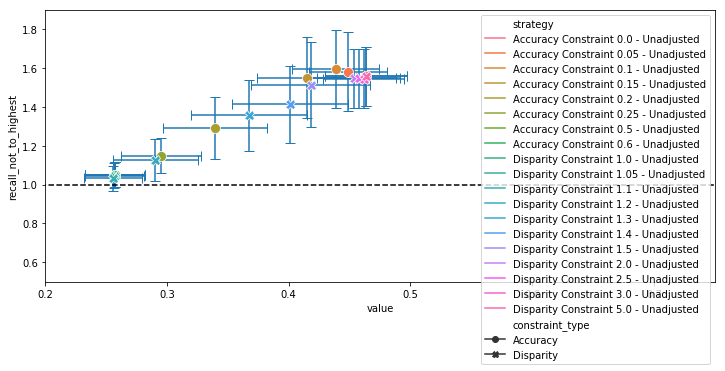

In [59]:
dc_df['dataset'] = 'donors_choose'
ts_df_1k = dc_df.copy()
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df_1k.groupby(['constraint_type', 'strategy'])[['value', 'recall_not_to_highest']].mean().reset_index(), 
              x='value', y='recall_not_to_highest', 
              hue='strategy',
#              hue='dataset', 
#              marker="o", 
              style='constraint_type',
              markers=True,
#              color='dodgerblue',
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


x_coords = list(ts_df_1k.groupby(['constraint_type', 'strategy'])[['value', 'recall_not_to_highest']].mean().reset_index()['value'].values)
y_coords = list(ts_df_1k.groupby(['constraint_type', 'strategy'])[['value', 'recall_not_to_highest']].mean().reset_index()['recall_not_to_highest'].values)
labels = list(ts_df_1k.groupby(['constraint_type', 'strategy'])['strategy'].min())

prec_errors = 1.96*ts_df_1k.groupby(['constraint_type', 'strategy'])['value'].sem().values
disp_errors = 1.96*ts_df_1k.groupby(['constraint_type', 'strategy'])['recall_not_to_highest'].sem().values
colors = sns.color_palette().as_hex()[0]
ax.errorbar(x_coords, y_coords, 
            xerr=prec_errors, 
            yerr=disp_errors,
            ecolor=colors, 
            fmt=' ', zorder=-1, capsize=5)


ax.hlines(1.0, 0, 1, linestyles='dashed')

ax.set_xlim((0.2,0.75))
ax.set_ylim((0.5,1.90))
#ax.get_legend().remove()

## Donors Choose (All Train End Times)

Looks like above was from an earlier run that only had a subset of the train_end_times; below is the full set

In [182]:
with open('db_default_profile.yaml') as fd:
    config = yaml.load(fd)
    dburl = sqlalchemy.engine.url.URL(
        "postgres",
        host=config["host"],
        username=config["user"],
        database='donors_kit',
        password=config["pass"],
        port=config["port"],
    )
    engine_donors3 = sqlalchemy.create_engine(dburl, poolclass=sqlalchemy.pool.QueuePool)

In [199]:
dc3_disp_cons_sql = """
WITH dist_res AS (
  SELECT DISTINCT * FROM kit_bias_all.model_adjustment_results_plevel
      WHERE list_size=1000
      AND train_end_time >= '2011-03-01'
)
, mg_rns_value AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base_value
  FROM dist_res
  WHERE past_train_end_time = train_end_time
    AND base_max_recall_ratio < {disparity_constraint}
)
, mg_rns_disp AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_max_recall_ratio ASC, base_value DESC, RANDOM()) AS rn_base_disparity
  FROM dist_res
  WHERE past_train_end_time = train_end_time
)
, base_mgs_hard_cons AS (
  -- Best-performaing (in terms of precision) model groups meeting the hard constraint on disparity
  SELECT * FROM mg_rns_value WHERE rn_base_value = 1
)
, base_mgs_soft_cons AS (
  -- For time/size/metric combinations with no model groups meeting the hard constraint, fill in with lowest-disparity model group
  SELECT
      COALESCE(h.model_group_id, d.model_group_id) AS model_group_id,
      COALESCE(h.train_end_time, d.train_end_time) AS train_end_time,
      COALESCE(h.list_size, d.list_size) AS list_size,
      COALESCE(h.metric, d.metric) AS metric,
      COALESCE(h.parameter, d.parameter) AS parameter
  FROM (SELECT * FROM mg_rns_disp WHERE rn_base_disparity = 1) as d
  LEFT JOIN base_mgs_hard_cons h USING(train_end_time, list_size, metric, parameter)
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Disparity <= {disparity_constraint}'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_highest_to_not_highest AS recall_highest_to_not,
       r.base_recall_not_highest_to_highest AS recall_not_to_highest,
       r.base_frac_highest AS frac_highest,
       r.base_frac_not_highest AS frac_not_highest
FROM dist_res r
JOIN base_mgs_soft_cons b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
ORDER BY train_end_time
;
"""


In [200]:
dc3_value_cons_sql = """
WITH dist_res AS (
  SELECT DISTINCT * FROM  kit_bias_all.model_adjustment_results_plevel
      WHERE list_size=1000
      AND train_end_time >= '2011-03-01'
)
, mg_rns_value AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base_value
  FROM dist_res
  WHERE past_train_end_time = train_end_time
)
, best_mgs AS (
  SELECT * FROM mg_rns_value WHERE rn_base_value = 1
)
, value_dist_cons AS (
  SELECT r.*,
         row_number() OVER (PARTITION BY r.train_end_time, r.list_size, r.metric, r.parameter ORDER BY r.base_max_recall_ratio ASC, r.base_value DESC, RANDOM()) AS rn_base_disparity
  FROM dist_res r
  JOIN best_mgs b USING(train_end_time, list_size, metric, parameter)
  WHERE b.base_value - r.base_value <= {value_constraint}
)
, base_mgs_value_cons AS (
  -- Lowest-disparity model groups within hard constraint distance from best model group in terms of metric value
  SELECT * FROM value_dist_cons WHERE rn_base_disparity = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Accuracy Loss <= {value_constraint}'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_highest_to_not_highest AS recall_highest_to_not,
       r.base_recall_not_highest_to_highest AS recall_not_to_highest,
       r.base_frac_highest AS frac_highest,
       r.base_frac_not_highest AS frac_not_highest
FROM dist_res r
JOIN base_mgs_value_cons b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
ORDER BY train_end_time
;
"""


In [233]:
dc3_res_dfs = []
# dc3_sort_ord = []

for c in reversed([1.0, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 2.0, 2.5, 3.0, 5.0]):
    df = pd.read_sql(dc3_disp_cons_sql.format(disparity_constraint=c), engine_donors)
    dc3_res_dfs.append(df)
#    dc3_sort_ord.append('Disparity <= %s' % c)

for c in [0.6, 0.5, 0.25, 0.2, 0.15, 0.10, 0.05, 0.0]:
    df = pd.read_sql(dc3_value_cons_sql.format(value_constraint=c), engine_donors)
    dc3_res_dfs.append(df)
#    dc3_sort_ord.append('Accuracy Loss <= %s' % c)

dc3_df = pd.concat(dc3_res_dfs)

In [261]:
dc3_res_dfs = []
# dc3_sort_ord = []

for c in reversed([1.0, 1.05, 1.1, 1.2, 1.3, 1.5, 2.0, 5.0]):
    df = pd.read_sql(dc3_disp_cons_sql.format(disparity_constraint=c), engine_donors)
    dc3_res_dfs.append(df)
#    dc3_sort_ord.append('Disparity <= %s' % c)

for c in [0.6, 0.5, 0.25, 0.2, 0.15, 0.10, 0.05, 0.0]:
    df = pd.read_sql(dc3_value_cons_sql.format(value_constraint=c), engine_donors)
    dc3_res_dfs.append(df)
#    dc3_sort_ord.append('Accuracy Loss <= %s' % c)

dc3_df = pd.concat(dc3_res_dfs)

In [262]:
dc3_df['constraint_type'] = dc3_df['strategy'].map(lambda x: x.split(' ')[0])

(0.5, 1.9)

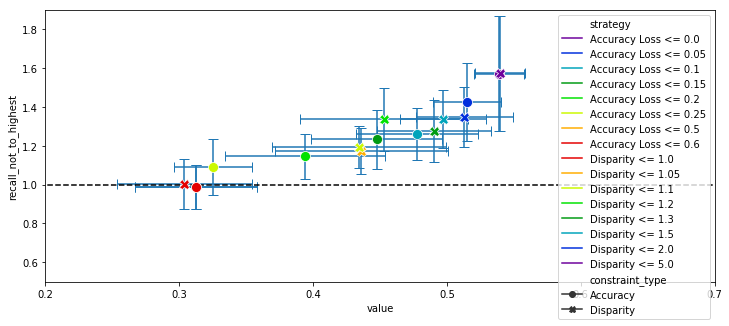

In [263]:
dc3_df['dataset'] = 'donors_choose'
ts_df_1k = dc3_df.copy()
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df_1k.groupby(['constraint_type', 'strategy'])[['value', 'recall_not_to_highest']].mean().reset_index(), 
              x='value', y='recall_not_to_highest', 
              hue='strategy',
#              palette=sns.color_palette("nipy_spectral", 8) + list(reversed(sns.color_palette("nipy_spectral", 11))),
              palette=sns.color_palette("nipy_spectral", 8) + list(reversed(sns.color_palette("nipy_spectral", 8))),
#              hue_order=dc3_sort_ord,
#              hue='dataset', 
#              marker="o", 
              style='constraint_type',
              markers=True,
#              color='dodgerblue',
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


x_coords = list(ts_df_1k.groupby(['constraint_type', 'strategy'])[['value', 'recall_not_to_highest']].mean().reset_index()['value'].values)
y_coords = list(ts_df_1k.groupby(['constraint_type', 'strategy'])[['value', 'recall_not_to_highest']].mean().reset_index()['recall_not_to_highest'].values)
labels = list(ts_df_1k.groupby(['constraint_type', 'strategy'])['strategy'].min())

prec_errors = 1.96*ts_df_1k.groupby(['constraint_type', 'strategy'])['value'].sem().values
disp_errors = 1.96*ts_df_1k.groupby(['constraint_type', 'strategy'])['recall_not_to_highest'].sem().values
colors = sns.color_palette().as_hex()[0]
ax.errorbar(x_coords, y_coords, 
            xerr=prec_errors, 
            yerr=disp_errors,
            ecolor=colors, 
            fmt=' ', zorder=-1, capsize=5)


ax.hlines(1.0, 0, 1, linestyles='dashed')

ax.set_xlim((0.2,0.7))
ax.set_ylim((0.5,1.90))
#ax.get_legend().remove()

Migrate the `kit_bias_all` tables from the extracted DB to the current working DB

In [189]:
import ohio.ext.pandas

In [190]:
exp_df = pd.read_sql('SELECT * FROM kit_bias_all.model_adjustment_results_plevel', engine_donors3)
exp_df.to_csv('dc__kit_bias_all__model_adjustment_results_plevel.csv', index=False)

In [192]:
exp_df.to_sql('model_adjustment_results_plevel', engine_donors, schema='kit_bias_all', index=False)

In [193]:
exp_df = pd.read_sql('SELECT * FROM kit_bias_all.composite_results_plevel', engine_donors3)
exp_df.to_csv('dc__kit_bias_all__composite_results_plevel.csv', index=False)

In [194]:
exp_df.to_sql('composite_results_plevel', engine_donors, schema='kit_bias_all', index=False)

In [198]:
engine_donors3.dispose()

## Donors Plot Updates

In [275]:
dc3_original_sql = """
WITH dist_res AS (
  SELECT DISTINCT * FROM  kit_bias_all.model_adjustment_results_plevel
      WHERE list_size=1000
      AND train_end_time >= '2011-03-01'
)
, mg_rns_value AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base_value
  FROM dist_res
  WHERE past_train_end_time = train_end_time
)
, best_mgs AS (
  SELECT * FROM mg_rns_value WHERE rn_base_value = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Original'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_highest_to_not_highest AS recall_highest_to_not,
       r.base_recall_not_highest_to_highest AS recall_not_to_highest,
       r.base_frac_highest AS frac_highest,
       r.base_frac_not_highest AS frac_not_highest
FROM dist_res r
JOIN best_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
ORDER BY train_end_time
;
"""


In [297]:
dc3_res_dfs = []
# dc3_sort_ord = []

letters = list(reversed(list('ABCDEFGH')))

for i, c in enumerate([1.0, 1.05, 1.1, 1.2, 1.3, 1.5, 2.0, 5.0]):
    df = pd.read_sql(dc3_disp_cons_sql.format(disparity_constraint=c), engine_donors)
    df['Level'] = letters[i]
    dc3_res_dfs.append(df)
#    dc3_sort_ord.append('Disparity <= %s' % c)

for i, c in enumerate([0.6, 0.5, 0.25, 0.2, 0.15, 0.10, 0.05, 0.0]):
    df = pd.read_sql(dc3_value_cons_sql.format(value_constraint=c), engine_donors)
    df['Level'] = letters[i]
    dc3_res_dfs.append(df)
#    dc3_sort_ord.append('Accuracy Loss <= %s' % c)

df = pd.read_sql(dc3_original_sql, engine_donors)
df['Level'] = 'Original'
dc3_res_dfs.append(df)

dc3_df = pd.concat(dc3_res_dfs)
dc3_df['Constraint Type'] = dc3_df['strategy'].map(lambda x: x.split(' ')[0])
dc3_df['dataset'] = 'donors_choose'

(0.5, 1.9)

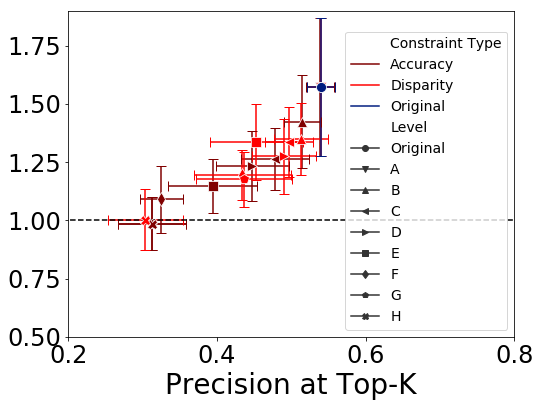

In [364]:
ts_df_1k = dc3_df.copy()

colorlist = ['maroon', 
             'red',
             '#001c7f', #Original
             ]

fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(data=ts_df_1k.groupby(['Constraint Type', 'Level'])[['value', 'recall_not_to_highest']].mean().reset_index(), 
              x='value', y='recall_not_to_highest', 
              hue='Constraint Type',
              hue_order=['Accuracy', 'Disparity', 'Original'],
#              palette=sns.color_palette("nipy_spectral", 8) + list(reversed(sns.color_palette("nipy_spectral", 11))),
#              palette=sns.color_palette("nipy_spectral", 3),
              palette=colorlist,
#              hue_order=dc3_sort_ord,
#              hue='dataset', 
#              marker="o", 
              style='Level',
              markers=['o', 'v', '^', '<', '>', 's', 'd', 'p', 'X'],
              style_order=['Original'] + list(reversed(letters))[:8],
#              color='dodgerblue',
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


for i, t in enumerate(['Accuracy', 'Disparity', 'Original']):
    tmp_df = ts_df_1k.loc[ts_df_1k['Constraint Type'] == t].copy()

    x_coords = list(tmp_df.groupby(['Constraint Type', 'Level'])[['value', 'recall_not_to_highest']].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['Constraint Type', 'Level'])[['value', 'recall_not_to_highest']].mean().reset_index()['recall_not_to_highest'].values)
    labels = list(tmp_df.groupby(['Constraint Type', 'Level'])['Level'].min())

    prec_errors = 1.96*tmp_df.groupby(['Constraint Type', 'Level'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['Constraint Type', 'Level'])['recall_not_to_highest'].sem().values
    colors = colorlist[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
                ecolor=colors, 
                fmt=' ', zorder=-1, capsize=5)


ax.hlines(1.0, 0, 1, linestyles='dashed')

ax.legend(loc='lower right', fontsize=14)

ax.set_ylabel('', fontsize=32)
ax.set_xlabel('Precision at Top-K', fontsize=28)

ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)

ax.set_xlim((0.2,0.80))
ax.set_ylim((0.5,1.90))
#ax.get_legend().remove()


## San Jose Housing

In [60]:
with open('db_big_profile.yaml') as fd:
    config = yaml.load(fd)
    dburl = sqlalchemy.engine.url.URL(
        "postgres",
        host=config["host"],
        username=config["user"],
        database='san_jose_housing',
        password=config["pass"],
        port=config["port"],
    )
    engine_sj = sqlalchemy.create_engine(dburl, poolclass=sqlalchemy.pool.QueuePool)

In [67]:
sj_disp_cons_sql = """
WITH dist_res AS (
  SELECT DISTINCT * FROM kit_bias_adj.model_adjustment_results_median_income 
      WHERE list_size=500 AND train_end_time >= '2013-06-01'
)
, mg_rns_value AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base_value
  FROM dist_res
  WHERE past_train_end_time = train_end_time
    AND base_max_recall_ratio < {disparity_constraint}
)
, mg_rns_disp AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_max_recall_ratio ASC, base_value DESC, RANDOM()) AS rn_base_disparity
  FROM dist_res
  WHERE past_train_end_time = train_end_time
)
, base_mgs_hard_cons AS (
  -- Best-performaing (in terms of precision) model groups meeting the hard constraint on disparity
  SELECT * FROM mg_rns_value WHERE rn_base_value = 1
)
, base_mgs_soft_cons AS (
  -- For time/size/metric combinations with no model groups meeting the hard constraint, fill in with lowest-disparity model group
  SELECT
      COALESCE(h.model_group_id, d.model_group_id) AS model_group_id,
      COALESCE(h.train_end_time, d.train_end_time) AS train_end_time,
      COALESCE(h.list_size, d.list_size) AS list_size,
      COALESCE(h.metric, d.metric) AS metric,
      COALESCE(h.parameter, d.parameter) AS parameter
  FROM (SELECT * FROM mg_rns_disp WHERE rn_base_disparity = 1) as d
  LEFT JOIN base_mgs_hard_cons h USING(train_end_time, list_size, metric, parameter)
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Disparity Constraint {disparity_constraint} - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_over55k_to_under55k AS recall_over55k_to_under55k,
       r.base_recall_under55k_to_over55k AS recall_under55k_to_over55k,
       r.base_frac_under55k AS frac_under55k,
       r.base_frac_over55k AS frac_over55k
FROM dist_res r
JOIN base_mgs_soft_cons b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
ORDER BY train_end_time
;
"""


In [69]:
sj_value_cons_sql = """
WITH dist_res AS (
  SELECT DISTINCT * FROM kit_bias_adj.model_adjustment_results_median_income 
      WHERE list_size=500 AND train_end_time >= '2013-06-01'
)
, mg_rns_value AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base_value
  FROM dist_res
  WHERE past_train_end_time = train_end_time
)
, best_mgs AS (
  SELECT * FROM mg_rns_value WHERE rn_base_value = 1
)
, value_dist_cons AS (
  SELECT r.*,
         row_number() OVER (PARTITION BY r.train_end_time, r.list_size, r.metric, r.parameter ORDER BY r.base_max_recall_ratio ASC, r.base_value DESC, RANDOM()) AS rn_base_disparity
  FROM dist_res r
  JOIN best_mgs b USING(train_end_time, list_size, metric, parameter)
  WHERE b.base_value - r.base_value <= {value_constraint}
)
, base_mgs_value_cons AS (
  -- Lowest-disparity model groups within hard constraint distance from best model group in terms of metric value
  SELECT * FROM value_dist_cons WHERE rn_base_disparity = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Accuracy Constraint {value_constraint} - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_over55k_to_under55k AS recall_over55k_to_under55k,
       r.base_recall_under55k_to_over55k AS recall_under55k_to_over55k,
       r.base_frac_under55k AS frac_under55k,
       r.base_frac_over55k AS frac_over55k
FROM dist_res r
JOIN base_mgs_value_cons b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
ORDER BY train_end_time
;
"""


In [71]:
sj_res_dfs = []

for c in [1.0, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 2.0, 2.5, 3.0, 5.0]:
    df = pd.read_sql(sj_disp_cons_sql.format(disparity_constraint=c), engine_sj)
    sj_res_dfs.append(df)

for c in [0.6, 0.5, 0.25, 0.2, 0.15, 0.10, 0.05, 0.0]:
    df = pd.read_sql(sj_value_cons_sql.format(value_constraint=c), engine_sj)
    sj_res_dfs.append(df)

sj_df = pd.concat(sj_res_dfs)

In [72]:
sj_df['constraint_type'] = sj_df['strategy'].map(lambda x: x.split('-')[0].split(' ')[0])

(0.5, 2.0)

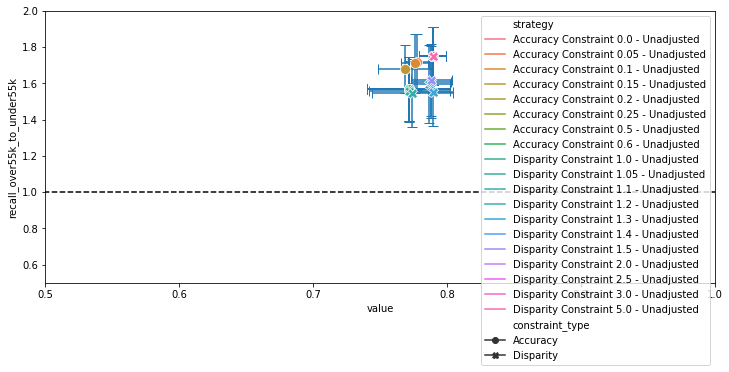

In [181]:
sj_df['dataset'] = 'san_jose_housing'
ts_df_1k = sj_df.copy()
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df_1k.groupby(['constraint_type', 'strategy'])[['value', 'recall_over55k_to_under55k']].mean().reset_index(), 
              x='value', y='recall_over55k_to_under55k', 
              hue='strategy',
#              hue='dataset', 
#              marker="o", 
              style='constraint_type',
              markers=True,
#              color='dodgerblue',
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


x_coords = list(ts_df_1k.groupby(['constraint_type', 'strategy'])[['value', 'recall_over55k_to_under55k']].mean().reset_index()['value'].values)
y_coords = list(ts_df_1k.groupby(['constraint_type', 'strategy'])[['value', 'recall_over55k_to_under55k']].mean().reset_index()['recall_over55k_to_under55k'].values)
labels = list(ts_df_1k.groupby(['constraint_type', 'strategy'])['strategy'].min())

prec_errors = 1.96*ts_df_1k.groupby(['constraint_type', 'strategy'])['value'].sem().values
disp_errors = 1.96*ts_df_1k.groupby(['constraint_type', 'strategy'])['recall_over55k_to_under55k'].sem().values
colors = sns.color_palette().as_hex()[0]
ax.errorbar(x_coords, y_coords, 
            xerr=prec_errors, 
            yerr=disp_errors,
            ecolor=colors, 
            fmt=' ', zorder=-1, capsize=5)


ax.hlines(1.0, 0, 1, linestyles='dashed')

ax.set_xlim((0.5,1.0))
ax.set_ylim((0.5,2.0))
#ax.get_legend().remove()

## San Jose Plotting

In [349]:
sj_original_sql = """
WITH dist_res AS (
  SELECT DISTINCT * FROM kit_bias_adj.model_adjustment_results_median_income 
      WHERE list_size=500 AND train_end_time >= '2013-06-01'
)
, mg_rns_value AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base_value
  FROM dist_res
  WHERE past_train_end_time = train_end_time
)
, best_mgs AS (
  SELECT * FROM mg_rns_value WHERE rn_base_value = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Original'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_over55k_to_under55k AS recall_over55k_to_under55k,
       r.base_recall_under55k_to_over55k AS recall_under55k_to_over55k,
       r.base_frac_under55k AS frac_under55k,
       r.base_frac_over55k AS frac_over55k
FROM dist_res r
JOIN best_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
ORDER BY train_end_time
;
"""


In [350]:
sj_res_dfs = []

letters = list(reversed(list('ABCDEFGH')))

for i, c in enumerate([1.0, 1.05, 1.1, 1.2, 1.3, 1.5, 2.0, 5.0]):
    df = pd.read_sql(sj_disp_cons_sql.format(disparity_constraint=c), engine_sj)
    df['Level'] = letters[i]
    sj_res_dfs.append(df)

for i, c in enumerate([0.6, 0.5, 0.25, 0.2, 0.15, 0.10, 0.05, 0.0]):
    df = pd.read_sql(sj_value_cons_sql.format(value_constraint=c), engine_sj)
    df['Level'] = letters[i]
    sj_res_dfs.append(df)

df = pd.read_sql(sj_original_sql, engine_sj)
df['Level'] = 'Original'
sj_res_dfs.append(df)

sj_df = pd.concat(sj_res_dfs)
sj_df['Constraint Type'] = sj_df['strategy'].map(lambda x: x.split(' ')[0])
sj_df['dataset'] = 'san_jose_housing'

(0.5, 2.0)

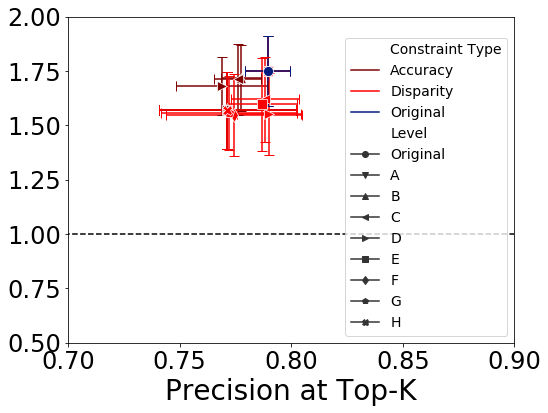

In [373]:
ts_df_1k = sj_df.copy()
disp_col = 'recall_over55k_to_under55k'

colorlist = ['maroon', 
             'red',
             '#001c7f', #Original
             ]

fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(data=ts_df_1k.groupby(['Constraint Type', 'Level'])[['value', disp_col]].mean().reset_index(), 
              x='value', y=disp_col, 
              hue='Constraint Type',
              hue_order=['Accuracy', 'Disparity', 'Original'],
#              palette=sns.color_palette("nipy_spectral", 8) + list(reversed(sns.color_palette("nipy_spectral", 11))),
#              palette=sns.color_palette("nipy_spectral", 3),
              palette=colorlist,
#              hue_order=dc3_sort_ord,
#              hue='dataset', 
#              marker="o", 
              style='Level',
              markers=['o', 'v', '^', '<', '>', 's', 'd', 'p', 'X'],
              style_order=['Original'] + list(reversed(letters))[:8],
#              color='dodgerblue',
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


for i, t in enumerate(['Accuracy', 'Disparity', 'Original']):
    tmp_df = ts_df_1k.loc[ts_df_1k['Constraint Type'] == t].copy()

    x_coords = list(tmp_df.groupby(['Constraint Type', 'Level'])[['value', disp_col]].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['Constraint Type', 'Level'])[['value', disp_col]].mean().reset_index()[disp_col].values)
    labels = list(tmp_df.groupby(['Constraint Type', 'Level'])['Level'].min())

    prec_errors = 1.96*tmp_df.groupby(['Constraint Type', 'Level'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['Constraint Type', 'Level'])[disp_col].sem().values
    colors = colorlist[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
                ecolor=colors, 
                fmt=' ', zorder=-1, capsize=5)


ax.hlines(1.0, 0, 1, linestyles='dashed')

ax.legend(loc='lower right', fontsize=14)

ax.set_ylabel('', fontsize=32)
ax.set_xlabel('Precision at Top-K', fontsize=28)

ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)

ax.set_xlim((0.7,0.9))
ax.set_ylim((0.5,2.0))
#ax.get_legend().remove()


## El Salvador

In [137]:
with open('db_big_profile.yaml') as fd:
    config = yaml.load(fd)
    dburl = sqlalchemy.engine.url.URL(
        "postgres",
        host=config["host"],
        username=config["user"],
        database='el_salvador_mined',
        password=config["pass"],
        port=config["port"],
    )
    engine_mined = sqlalchemy.create_engine(dburl, poolclass=sqlalchemy.pool.QueuePool)

In [174]:
mined_disp_cons_sql = """
WITH dist_res AS (
  SELECT DISTINCT * FROM bias_analysis_1year_all_models.model_adjustment_results_ovg 
      WHERE list_size=10000 
    AND train_end_time >= '2011-01-01'
)
, mg_rns_value AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base_value
  FROM dist_res
  WHERE past_train_end_time = train_end_time
    AND base_max_recall_ratio < {disparity_constraint}
)
, mg_rns_disp AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_max_recall_ratio ASC, base_value DESC, RANDOM()) AS rn_base_disparity
  FROM dist_res
  WHERE past_train_end_time = train_end_time
)
, base_mgs_hard_cons AS (
  -- Best-performaing (in terms of precision) model groups meeting the hard constraint on disparity
  SELECT * FROM mg_rns_value WHERE rn_base_value = 1
)
, base_mgs_soft_cons AS (
  -- For time/size/metric combinations with no model groups meeting the hard constraint, fill in with lowest-disparity model group
  SELECT
      COALESCE(h.model_group_id, d.model_group_id) AS model_group_id,
      COALESCE(h.train_end_time, d.train_end_time) AS train_end_time,
      COALESCE(h.list_size, d.list_size) AS list_size,
      COALESCE(h.metric, d.metric) AS metric,
      COALESCE(h.parameter, d.parameter) AS parameter
  FROM (SELECT * FROM mg_rns_disp WHERE rn_base_disparity = 1) as d
  LEFT JOIN base_mgs_hard_cons h USING(train_end_time, list_size, metric, parameter)
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Disparity Constraint {disparity_constraint} - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_0_to_1 AS recall_not_to_over,
       r.base_recall_1_to_0 AS recall_over_to_not,
       r.base_frac_0 AS frac_not,
       r.base_frac_1 AS frac_over
FROM dist_res r
JOIN base_mgs_soft_cons b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
ORDER BY train_end_time
;
"""


In [175]:
mined_value_cons_sql = """
WITH dist_res AS (
  SELECT DISTINCT * FROM bias_analysis_1year_all_models.model_adjustment_results_ovg 
    WHERE list_size=10000 
    AND train_end_time >= '2011-01-01'
)
, mg_rns_value AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base_value
  FROM dist_res
  WHERE past_train_end_time = train_end_time
)
, best_mgs AS (
  SELECT * FROM mg_rns_value WHERE rn_base_value = 1
)
, value_dist_cons AS (
  SELECT r.*,
         row_number() OVER (PARTITION BY r.train_end_time, r.list_size, r.metric, r.parameter ORDER BY r.base_max_recall_ratio ASC, r.base_value DESC, RANDOM()) AS rn_base_disparity
  FROM dist_res r
  JOIN best_mgs b USING(train_end_time, list_size, metric, parameter)
  WHERE b.base_value - r.base_value <= {value_constraint}
)
, base_mgs_value_cons AS (
  -- Lowest-disparity model groups within hard constraint distance from best model group in terms of metric value
  SELECT * FROM value_dist_cons WHERE rn_base_disparity = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Accuracy Constraint {value_constraint} - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_0_to_1 AS recall_not_to_over,
       r.base_recall_1_to_0 AS recall_over_to_not,
       r.base_frac_0 AS frac_not,
       r.base_frac_1 AS frac_over
FROM dist_res r
JOIN base_mgs_value_cons b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
ORDER BY train_end_time
;
"""


In [176]:
mined_res_dfs = []

for c in [1.0, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 2.0, 2.5, 3.0, 5.0]:
    df = pd.read_sql(mined_disp_cons_sql.format(disparity_constraint=c), engine_mined)
    mined_res_dfs.append(df)

for c in [0.6, 0.5, 0.25, 0.2, 0.15, 0.10, 0.05, 0.0]:
    df = pd.read_sql(mined_value_cons_sql.format(value_constraint=c), engine_mined)
    mined_res_dfs.append(df)

mined_df = pd.concat(mined_res_dfs)

In [177]:
mined_df['constraint_type'] = mined_df['strategy'].map(lambda x: x.split('-')[0].split(' ')[0])

(0.0, 5.3)

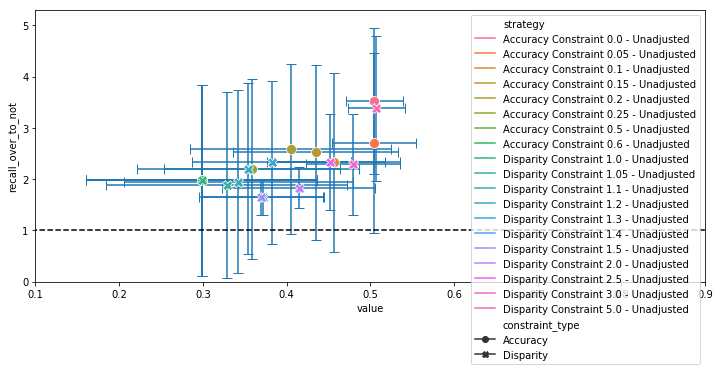

In [178]:
mined_df['dataset'] = 'el_salvador_mined'
ts_df_1k = mined_df.copy()
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df_1k.groupby(['constraint_type', 'strategy'])[['value', 'recall_over_to_not']].mean().reset_index(), 
              x='value', y='recall_over_to_not', 
              hue='strategy',
#              hue='dataset', 
#              marker="o", 
              style='constraint_type',
              markers=True,
#              color='dodgerblue',
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


x_coords = list(ts_df_1k.groupby(['constraint_type', 'strategy'])[['value', 'recall_over_to_not']].mean().reset_index()['value'].values)
y_coords = list(ts_df_1k.groupby(['constraint_type', 'strategy'])[['value', 'recall_over_to_not']].mean().reset_index()['recall_over_to_not'].values)
labels = list(ts_df_1k.groupby(['constraint_type', 'strategy'])['strategy'].min())

prec_errors = 1.96*ts_df_1k.groupby(['constraint_type', 'strategy'])['value'].sem().values
disp_errors = 1.96*ts_df_1k.groupby(['constraint_type', 'strategy'])['recall_over_to_not'].sem().values
colors = sns.color_palette().as_hex()[0]
ax.errorbar(x_coords, y_coords, 
            xerr=prec_errors, 
            yerr=disp_errors,
            ecolor=colors, 
            fmt=' ', zorder=-1, capsize=5)


ax.hlines(1.0, 0, 1, linestyles='dashed')

ax.set_xlim((0.1,0.9))
ax.set_ylim((0.0,5.30))
#ax.get_legend().remove()

## El Salvador Plotting

In [354]:
mined_original_sql = """
WITH dist_res AS (
  SELECT DISTINCT * FROM bias_analysis_1year_all_models.model_adjustment_results_ovg 
    WHERE list_size=10000 
    AND train_end_time >= '2011-01-01'
)
, mg_rns_value AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base_value
  FROM dist_res
  WHERE past_train_end_time = train_end_time
)
, best_mgs AS (
  SELECT * FROM mg_rns_value WHERE rn_base_value = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Original'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_0_to_1 AS recall_not_to_over,
       r.base_recall_1_to_0 AS recall_over_to_not,
       r.base_frac_0 AS frac_not,
       r.base_frac_1 AS frac_over
FROM dist_res r
JOIN best_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
ORDER BY train_end_time
;
"""



In [355]:
mined_res_dfs = []

letters = list(reversed(list('ABCDEFGH')))

for i, c in enumerate([1.0, 1.05, 1.1, 1.2, 1.3, 1.5, 2.0, 5.0]):
    df = pd.read_sql(mined_disp_cons_sql.format(disparity_constraint=c), engine_mined)
    df['Level'] = letters[i]
    mined_res_dfs.append(df)

for i, c in enumerate([0.6, 0.5, 0.25, 0.2, 0.15, 0.10, 0.05, 0.0]):
    df = pd.read_sql(mined_value_cons_sql.format(value_constraint=c), engine_mined)
    df['Level'] = letters[i]
    mined_res_dfs.append(df)

df = pd.read_sql(mined_original_sql, engine_mined)
df['Level'] = 'Original'
mined_res_dfs.append(df)

mined_df = pd.concat(mined_res_dfs)
mined_df['Constraint Type'] = mined_df['strategy'].map(lambda x: x.split(' ')[0])
mined_df['dataset'] = 'el_salvador_mined'

(0.0, 5.3)

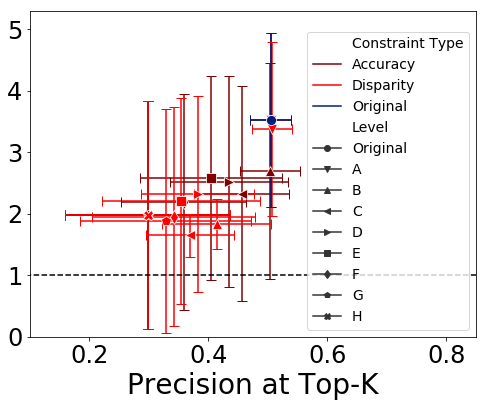

In [375]:
ts_df_1k = mined_df.copy()
disp_col = 'recall_over_to_not'

colorlist = ['maroon', 
             'red',
             '#001c7f', #Original
             ]

fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(data=ts_df_1k.groupby(['Constraint Type', 'Level'])[['value', disp_col]].mean().reset_index(), 
              x='value', y=disp_col, 
              hue='Constraint Type',
              hue_order=['Accuracy', 'Disparity', 'Original'],
#              palette=sns.color_palette("nipy_spectral", 8) + list(reversed(sns.color_palette("nipy_spectral", 11))),
#              palette=sns.color_palette("nipy_spectral", 3),
              palette=colorlist,
#              hue_order=dc3_sort_ord,
#              hue='dataset', 
#              marker="o", 
              style='Level',
              markers=['o', 'v', '^', '<', '>', 's', 'd', 'p', 'X'],
              style_order=['Original'] + list(reversed(letters))[:8],
#              color='dodgerblue',
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


for i, t in enumerate(['Accuracy', 'Disparity', 'Original']):
    tmp_df = ts_df_1k.loc[ts_df_1k['Constraint Type'] == t].copy()

    x_coords = list(tmp_df.groupby(['Constraint Type', 'Level'])[['value', disp_col]].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['Constraint Type', 'Level'])[['value', disp_col]].mean().reset_index()[disp_col].values)
    labels = list(tmp_df.groupby(['Constraint Type', 'Level'])['Level'].min())

    prec_errors = 1.96*tmp_df.groupby(['Constraint Type', 'Level'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['Constraint Type', 'Level'])[disp_col].sem().values
    colors = colorlist[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
                ecolor=colors, 
                fmt=' ', zorder=-1, capsize=5)


ax.hlines(1.0, 0, 1, linestyles='dashed')

ax.legend(loc='lower right', fontsize=14)

ax.set_ylabel('', fontsize=32)
ax.set_xlabel('Precision at Top-K', fontsize=28)

ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)

ax.set_xlim((0.1,0.85))
ax.set_ylim((0.0,5.3))
#ax.get_legend().remove()
